In [15]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [8]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [10]:
num_epochs=10
batch_size=32
learning_rate=0.001

transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [12]:
train_dataset=torchvision.datasets.CIFAR10(root='./data',download=True,transform=transform)
test_dataset=torchvision.datasets.CIFAR10(root='./data',train=False,transform=transform)

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


In [13]:
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

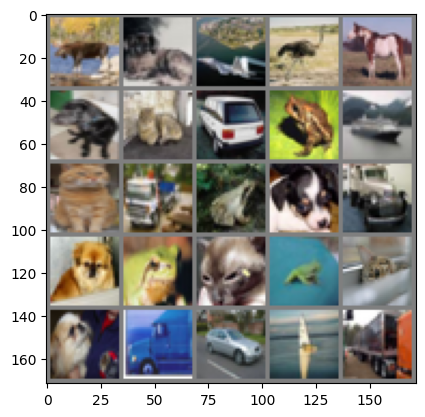

In [14]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(imgs):
  imgs=imgs/2+0.5
  npimgs=imgs.numpy()
  plt.imshow(np.transpose(npimgs,(1,2,0)))
  plt.show()

dataiter=iter(train_loader)
images,labels=next(dataiter)
img_grid=torchvision.utils.make_grid(images[0:25],nrow=5)
imshow(img_grid)

In [19]:
class ConvNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1=nn.Conv2d(3,32,3)
    self.pool=nn.MaxPool2d(2,2)
    self.conv2=nn.Conv2d(32,64,3)
    self.conv3=nn.Conv2d(64,64,3)
    self.fc1=nn.Linear(64*4*4,64)
    self.fc2=nn.Linear(64,10)

  def forward(self,x):
    #N,3,32,32
    x=F.relu(self.conv1(x)) #N,32,30,30
    x=self.pool(x) #N,32,15,15
    x=F.relu(self.conv2(x)) #N,64,13,13
    x=self.pool(x) #N,64,6,6
    x=F.relu(self.conv3(x)) #N,64,4,4
    x=torch.flatten(x,1) #N,1024
    x=F.relu(self.fc1(x)) #N,64
    x=self.fc2(x) #N,10
    return x


In [20]:
  model=ConvNN().to(device)

In [21]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

In [22]:
n_total_steps=len(train_loader)
for epoch in range(num_epochs):
  running_loss=0

  for i,(images,labels) in enumerate(train_loader):
    images=images.to(device)
    labels=labels.to(device)

    outputs=model(images)
    loss=criterion(outputs,labels)

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    running_loss+=loss.item()

  print(f'Epoch:{epoch+1}, Loss:{running_loss/n_total_steps:.3f}')

Epoch:1, Loss:1.471
Epoch:2, Loss:1.090
Epoch:3, Loss:0.918
Epoch:4, Loss:0.817
Epoch:5, Loss:0.741
Epoch:6, Loss:0.683
Epoch:7, Loss:0.634
Epoch:8, Loss:0.590
Epoch:9, Loss:0.552
Epoch:10, Loss:0.510


In [24]:
PATH='./cnn.pth'
torch.save(model.state_dict(),PATH)

loaded_model = ConvNN()
loaded_model.load_state_dict(torch.load(PATH)) # it takes the loaded dictionary, not the path file itself
loaded_model.to(device)
loaded_model.eval()

with torch.no_grad():
    n_correct = 0
    n_correct2 = 0
    n_samples = len(test_loader.dataset)

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)

        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_correct += (predicted == labels).sum().item()

        outputs2 = loaded_model(images)
        _, predicted2 = torch.max(outputs2, 1)
        n_correct2 += (predicted2 == labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the model: {acc} %')

    acc = 100.0 * n_correct2 / n_samples
    print(f'Accuracy of the loaded model: {acc} %')

Accuracy of the model: 72.29 %
Accuracy of the loaded model: 72.29 %
